### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [1]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [3]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Category'])


In [4]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)

In [5]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [6]:
data.Category.value_counts()

Software              18025
Application           16478
Monitoring            15225
Help/ Assistance       4699
Service Request         483
Network                 397
Database                354
Server                  139
Hardware                121
Cloud Computing          69
Security                 36
Help/Assistance          18
Storage                  13
Inquiry/Help             12
Backup                    4
End User Computing        1
Name: Category, dtype: int64

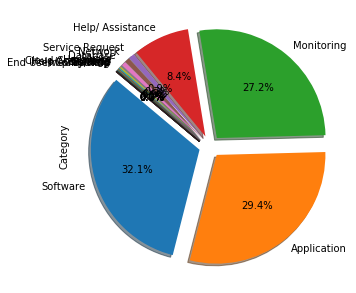

In [7]:
chart=data.Category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [8]:
data = data.groupby('Category').filter(lambda x : len(x)>4000)

In [9]:
data.Category.value_counts()

Software            18025
Application         16478
Monitoring          15225
Help/ Assistance     4699
Name: Category, dtype: int64

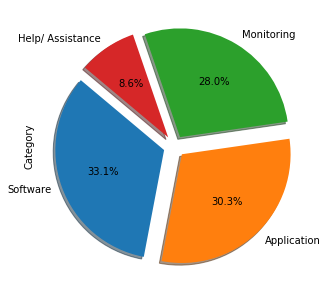

In [10]:
chart=data.Category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [11]:
from sklearn.utils import resample

df_1 = data[data.Category=='Software']
df_2 = data[data.Category=='Application']
df_3 = data[data.Category=='Monitoring']

df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=15225,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=15225,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=15225,    # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled])

In [12]:
data.Category.value_counts()

Monitoring     15225
Software       15225
Application    15225
Name: Category, dtype: int64

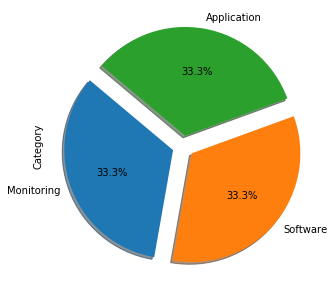

In [13]:
chart=data.Category.value_counts()
explode = (0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [14]:
data['target_cat'] = data.Category.astype('category').cat.codes

In [15]:
labels_cat = data.Category.astype('category').cat.categories

In [16]:
df = pd.DataFrame(labels_cat) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_cat.csv')

In [17]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_cat
51766,INC000020333284,New phone can't login to Concur SAP,New phone can't login to Concur SAP,GIUSEPPE GAUDIO (22750477),Priority 4,Software,Mobile,Low,Limited,LIFESCAN -US,...,Closed Complete,Configuration Error,NA US NJ TITUSVILLE,DESK SIDE SERVICES L2,NATHANIEL MOLES (645010775),KB000010044168,NaN,2019-06-12 15:43,2019-06-12 16:03,2
55214,INC000017860779,Wholesaler Onsell Data for API (Imbruvica) is ...,Other Issue,RITZ CASTROVERDE (151100126),Priority 4,Software,Enterprise software,Medium,Limited,JEEP.JNJ.COM-PROD,...,Closed Complete,Data Issue,ASPAC AU SYDNEY,PHARM ANZ BUSINESS INTELLIGENCE (BI) L2,MUNEER KHAN (643014357),NaN,ASPAC,2018-01-08 19:43,2018-01-12 6:59,2
51120,INC000018609299,"Team was the ""BWI Financial Daily Sales Summar...",Software - J&J business applications: Alert / ...,VAIBHAV SAMUDRA (340554),Priority 4,Software,Enterprise software,Low,Limited,BWI JDE DATAWAREHOUSE - PROD,...,Closed Complete,Data Issue,ASPAC IN KOLKATA,BWI L2,ADAPAKA JYOTIKA (643013432),NaN,NaN,2018-06-18 6:42,2018-06-21 2:42,2
25809,INC000016887537,Please see if we can maintain the customer cod...,Software - J&J business applications: Data mis...,WAI KIN CHAN (89111021),Priority 4,Software,Website,Low,Limited,ASPAC DNA PLATFORM,...,Closed Complete,Data Issue,ASPAC HK MONGKOK,ASPAC CONSUMER DNA L2,KESAVA PRADEEP (643018327),NaN,ASPAC,2017-06-02 8:08,2017-06-09 11:04,2
41053,INC000018958040,When did this issue begin?:\n\nWho is this aff...,Club Food Discount E-Comm data issue reported ...,ALAGURASU PALANIAPPAN (643012501),Priority 3,Software,Enterprise software,High,Limited,BIW-COGNOS-PROD (CONCA),...,Closed Complete,Data Issue,ASPAC IN BANGALORE,GLOBAL ANALYTICS CONSUMER,NITIN DABADE (643016775),NaN,NaN,2018-08-29 5:02,2018-08-31 8:17,2


In [18]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [19]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,60,130, np.inf], labels=['0-10', '10-30', '30-60','60-130' ,'>130'])


In [20]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [21]:
word_distribution.head()

,bins,counts
0,0-10,10057
1,10-30,20926
2,30-60,8908
3,60-130,4837
4,>130,947


Text(0.5, 1.0, 'Word distribution per bin')

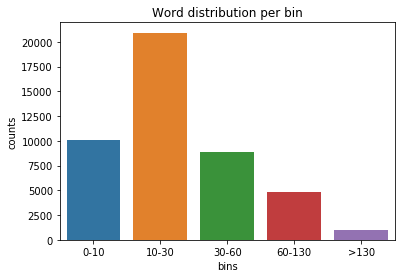

In [22]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [23]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_cat,num_words,bins
51766,INC000020333284,New phone can't login to Concur SAP,New phone can't login to Concur SAP,GIUSEPPE GAUDIO (22750477),Priority 4,Software,Mobile,Low,Limited,LIFESCAN -US,...,NA US NJ TITUSVILLE,DESK SIDE SERVICES L2,NATHANIEL MOLES (645010775),KB000010044168,NaN,2019-06-12 15:43,2019-06-12 16:03,2,7,0-10
55214,INC000017860779,Wholesaler Onsell Data for API (Imbruvica) is ...,Other Issue,RITZ CASTROVERDE (151100126),Priority 4,Software,Enterprise software,Medium,Limited,JEEP.JNJ.COM-PROD,...,ASPAC AU SYDNEY,PHARM ANZ BUSINESS INTELLIGENCE (BI) L2,MUNEER KHAN (643014357),NaN,ASPAC,2018-01-08 19:43,2018-01-12 6:59,2,8,0-10
51120,INC000018609299,"Team was the ""BWI Financial Daily Sales Summar...",Software - J&J business applications: Alert / ...,VAIBHAV SAMUDRA (340554),Priority 4,Software,Enterprise software,Low,Limited,BWI JDE DATAWAREHOUSE - PROD,...,ASPAC IN KOLKATA,BWI L2,ADAPAKA JYOTIKA (643013432),NaN,NaN,2018-06-18 6:42,2018-06-21 2:42,2,12,10-30
25809,INC000016887537,Please see if we can maintain the customer cod...,Software - J&J business applications: Data mis...,WAI KIN CHAN (89111021),Priority 4,Software,Website,Low,Limited,ASPAC DNA PLATFORM,...,ASPAC HK MONGKOK,ASPAC CONSUMER DNA L2,KESAVA PRADEEP (643018327),NaN,ASPAC,2017-06-02 8:08,2017-06-09 11:04,2,82,60-130
41053,INC000018958040,When did this issue begin?:\n\nWho is this aff...,Club Food Discount E-Comm data issue reported ...,ALAGURASU PALANIAPPAN (643012501),Priority 3,Software,Enterprise software,High,Limited,BIW-COGNOS-PROD (CONCA),...,ASPAC IN BANGALORE,GLOBAL ANALYTICS CONSUMER,NITIN DABADE (643016775),NaN,NaN,2018-08-29 5:02,2018-08-31 8:17,2,40,30-60


In [24]:
num_class_cat = len(np.unique(data.Category.values))
y_cat = data['target_cat'].values


## Topic Modelling

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [26]:
data['Description'] = data['Description'].astype(str)

In [27]:
type(data['Description'])

pandas.core.series.Series

In [28]:
data_description = data.Description.values

In [29]:
type(data_description)

numpy.ndarray

In [30]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

00000 11.036181094261593
000000000019804817 11.036181094261593
000000000019804824 11.036181094261593
000000000022006666 11.036181094261593
000000000043309730 11.036181094261593
000000000111809503 11.036181094261593
000000000304882800 11.036181094261593
000000000510007127 11.036181094261593
000000000514823578 11.036181094261593
000000000523062000 11.036181094261593
000000000523062500 11.036181094261593
0000000019 11.036181094261593
0000000024664419 11.036181094261593
000000059676036001 11.036181094261593
000000059676082001 11.036181094261593
0000013265 11.036181094261593
0000014860 11.036181094261593
0000020374 11.036181094261593
0000025578 11.036181094261593
000002_0 11.036181094261593
000004026995 11.036181094261593
000004026996 11.036181094261593
000004026997 11.036181094261593
000004026998 11.036181094261593
000004026999 11.036181094261593
000004027000 11.036181094261593
000004027001 11.036181094261593
000004027002 11.036181094261593
000004027003 11.036181094261593
000004027101 11.0

212051 11.036181094261593
21249 11.036181094261593
21250 11.036181094261593
21256 11.036181094261593
212597 11.036181094261593
2126 11.036181094261593
212867 11.036181094261593
2129 11.036181094261593
21319 11.036181094261593
213301 11.036181094261593
21364 11.036181094261593
21381 11.036181094261593
2139 11.036181094261593
213934 11.036181094261593
213960003 11.036181094261593
2140 11.036181094261593
214001 11.036181094261593
21409 11.036181094261593
2141 11.036181094261593
2142 11.036181094261593
2143 11.036181094261593
2144 11.036181094261593
2145 11.036181094261593
21455037 11.036181094261593
2146 11.036181094261593
2147 11.036181094261593
2147418112 11.036181094261593
2147954407 11.036181094261593
2147954556 11.036181094261593
2148 11.036181094261593
21483 11.036181094261593
2149 11.036181094261593
214914826 11.036181094261593
21494 11.036181094261593
2150 11.036181094261593
215023 11.036181094261593
2151 11.036181094261593
21518636 11.036181094261593
2152 11.036181094261593
2153 

4483309 11.036181094261593
4483316 11.036181094261593
4483681 11.036181094261593
4483682 11.036181094261593
4484451 11.036181094261593
4484466 11.036181094261593
4484467 11.036181094261593
4485892 11.036181094261593
4486377 11.036181094261593
4486690 11.036181094261593
4486802 11.036181094261593
4487629 11.036181094261593
4487965 11.036181094261593
4488905 11.036181094261593
4490698 11.036181094261593
4491257 11.036181094261593
4492 11.036181094261593
4492393 11.036181094261593
4492419 11.036181094261593
4493434 11.036181094261593
4493450 11.036181094261593
4493464 11.036181094261593
4493649 11.036181094261593
4494225 11.036181094261593
4494816 11.036181094261593
4497 11.036181094261593
4497196 11.036181094261593
4497754 11.036181094261593
4499536 11.036181094261593
4499547 11.036181094261593
4499985 11.036181094261593
44am 11.036181094261593
44ff 11.036181094261593
45000877 11.036181094261593
45000947 11.036181094261593
4500748 11.036181094261593
4500763 11.036181094261593
4500772 11.

8795 11.036181094261593
8795380 11.036181094261593
87df 11.036181094261593
87f3 11.036181094261593
87k 11.036181094261593
8801008002087 11.036181094261593
8801008003701 11.036181094261593
8801008600085 11.036181094261593
88163 11.036181094261593
88165 11.036181094261593
8830884 11.036181094261593
8837 11.036181094261593
883e 11.036181094261593
8850007813989 11.036181094261593
88561 11.036181094261593
886921226061 11.036181094261593
886930236234 11.036181094261593
8882269 11.036181094261593
8883655 11.036181094261593
88893 11.036181094261593
88ab1d56 11.036181094261593
8901012115145 11.036181094261593
8902911 11.036181094261593
89044106137 11.036181094261593
8905 11.036181094261593
890de8c5 11.036181094261593
8913975 11.036181094261593
8930507 11.036181094261593
8942551 11.036181094261593
8955114 11.036181094261593
8955225 11.036181094261593
896 11.036181094261593
89652333094 11.036181094261593
8966966 11.036181094261593
8967972 11.036181094261593
8972825 11.036181094261593
8982 11.0361

clmdb 11.036181094261593
clns 11.036181094261593
clnsrs 11.036181094261593
clog 11.036181094261593
clog000013206647 11.036181094261593
clog000013233852 11.036181094261593
clous 11.036181094261593
clow8 11.036181094261593
clr602 11.036181094261593
clse 11.036181094261593
clsnasd 11.036181094261593
clés 11.036181094261593
clínicas 11.036181094261593
cmd_jp_dw_dsj_sellindatasummary_1 11.036181094261593
cmd_jpn_workflow_batch_start 11.036181094261593
cmd_workflow_batch_start_modeln 11.036181094261593
cmdb_ci_appl_name 11.036181094261593
cmdb_ci_appl_updated 11.036181094261593
cmdb_ci_database_name 11.036181094261593
cmdb_ci_database_updated 11.036181094261593
cmdb_ci_name 11.036181094261593
cmdb_ci_server 11.036181094261593
cmdb_ci_server_name 11.036181094261593
cmdb_ci_server_updated 11.036181094261593
cmdb_ci_service 11.036181094261593
cmdb_ci_unix_server 11.036181094261593
cmdb_ci_updated 11.036181094261593
cmdb_ci_win_server 11.036181094261593
cmdb_db_instance 11.036181094261593
cme 11

feb17 11.036181094261593
febraury 11.036181094261593
feels 11.036181094261593
fefer 11.036181094261593
fefore 11.036181094261593
fehlermeldeung 11.036181094261593
fei 11.036181094261593
felix 11.036181094261593
female 11.036181094261593
feng 11.036181094261593
ferenckisfaludi 11.036181094261593
fernandes 11.036181094261593
fernandez 11.036181094261593
ferre 11.036181094261593
ferrer 11.036181094261593
fetchtype 11.036181094261593
fette 11.036181094261593
ff71 11.036181094261593
ffff 11.036181094261593
ffl 11.036181094261593
fhu 11.036181094261593
fi010_a002 11.036181094261593
fianance 11.036181094261593
ficam 11.036181094261593
fichier 11.036181094261593
fichiers 11.036181094261593
fidelityplananalytics 11.036181094261593
field_term 11.036181094261593
fieldtype 11.036181094261593
file_delimited_1_tftpconnection_1 11.036181094261593
file_meta_copyright 11.036181094261593
file_name 11.036181094261593
file_pl 11.036181094261593
fileid 11.036181094261593
filemaker 11.036181094261593
fileou

kielar 11.036181094261593
kijken 11.036181094261593
kilcoyne 11.036181094261593
kingslee 11.036181094261593
kit_order_line 11.036181094261593
kit_qty 11.036181094261593
kita 11.036181094261593
kits_app_script 11.036181094261593
kits_pu 11.036181094261593
kits_su 11.036181094261593
kitters 11.036181094261593
kkavalk 11.036181094261593
kkritman 11.036181094261593
kli48 11.036181094261593
kmanikan 11.036181094261593
knakamu5 11.036181094261593
knowing 11.036181094261593
knowlton 11.036181094261593
koc 11.036181094261593
koesters 11.036181094261593
kojcevski 11.036181094261593
kokilapriya 11.036181094261593
kol2 11.036181094261593
kol4 11.036181094261593
kol_flag 11.036181094261593
komachi 11.036181094261593
komachi_sell 11.036181094261593
komen 11.036181094261593
kommt 11.036181094261593
konfiguration 11.036181094261593
konkova 11.036181094261593
konsi3 11.036181094261593
kontakte 11.036181094261593
kontaktperson 11.036181094261593
konto 11.036181094261593
kopsete 11.036181094261593
korea

pinto 11.036181094261593
pipelines 11.036181094261593
pipemessagesource 11.036181094261593
pis 11.036181094261593
pitch 11.036181094261593
piyh5c 11.036181094261593
pizzo 11.036181094261593
piú 11.036181094261593
pkaur22 11.036181094261593
pkg_conca_biw_common_module 11.036181094261593
pkg_jde_new_products 11.036181094261593
pkg_mbox_download_jde 11.036181094261593
pkg_sf_user_role 11.036181094261593
pkgeg_lvl_cd 11.036181094261593
pkgeg_lvl_lbl_uom_cd 11.036181094261593
pklz 11.036181094261593
pl100 11.036181094261593
pl21 11.036181094261593
pl323 11.036181094261593
placeholder 11.036181094261593
placeholders 11.036181094261593
placeing 11.036181094261593
plain 11.036181094261593
planejou 11.036181094261593
planet 11.036181094261593
planisware 11.036181094261593
planned_del_date 11.036181094261593
planning_customer_code 11.036181094261593
planning_cycle 11.036181094261593
planning_cycle_id 11.036181094261593
planning_integration_job 11.036181094261593
planning_workflow 11.036181094261

ss060 11.036181094261593
ssc_latitude_janssen 11.036181094261593
ssc_latitude_janssen_zytiga 11.036181094261593
sss 11.036181094261593
st00000000000000000001131600 11.036181094261593
stabled 11.036181094261593
stadard 11.036181094261593
staffing 11.036181094261593
stage_request_form 11.036181094261593
stagefailed 11.036181094261593
staging_hive 11.036181094261593
staging_hive_2018 11.036181094261593
staging_mdtr_cepbrick 11.036181094261593
stake 11.036181094261593
stalerelationcleanersoldto 11.036181094261593
stalling 11.036181094261593
stand 11.036181094261593
standaarden 11.036181094261593
standard_cost 11.036181094261593
standard_price 11.036181094261593
standstill 11.036181094261593
star028 11.036181094261593
stared 11.036181094261593
starr 11.036181094261593
start_batch 11.036181094261593
startqueue 11.036181094261593
starttime 11.036181094261593
startwork 11.036181094261593
statafix 11.036181094261593
stateoscope 11.036181094261593
stati 11.036181094261593
statisticsdaily 11.0361

In [31]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [32]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['00000' 'kkritman' 'kli48' 'kmanikan' 'knakamu5' 'knowing' 'knowlton'
 'koc' 'koesters' 'kojcevski']

Features with highest idf:
['abovebo' 'abox' 'abqc' 'abraham' 'abreast' 'abreu' 'abrirlas'
 'absorbable' 'abiertos' 'último']


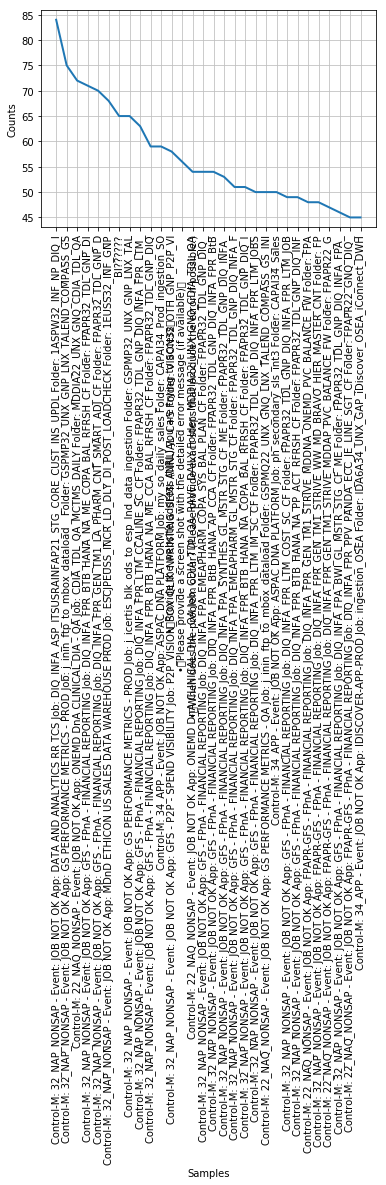

In [33]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [34]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(45675, 41006)
  (0, 29418)	0.34499857672390244
  (0, 31089)	0.47682161635575726
  (0, 14184)	0.27377735755392374
  (0, 26991)	0.3308438017437274
  (0, 38060)	0.15526417614930602
  (0, 15503)	0.5641840229902801
  (0, 34812)	0.3560827001977112
  (1, 40292)	0.47076028347086607
  (1, 30054)	0.5142099603501535
  (1, 16583)	0.15559074342947168
  (1, 20713)	0.1172693833176816
  (1, 12170)	0.3987252955562779
  (1, 23117)	0.48167367060787863
  (1, 24222)	0.11572363753329849
  (1, 23569)	0.2676358307873436
  (2, 37579)	0.2126900504968074
  (2, 39946)	0.23745469357678722
  (2, 37809)	0.09586189274649863
  (2, 13978)	0.37539675908982545
  (2, 20564)	0.16466504924287367
  (2, 16505)	0.2928132585477128
  (2, 34663)	0.1954328397485299
  (2, 36924)	0.37273987935346903
  (2, 33474)	0.22086749826874305
  (2, 16892)	0.4190836378441232
  :	:
  (45673, 2880)	0.10080584841498873
  (45673, 989)	0.13520823787653152
  (45673, 34184)	0.13627317506791445
  (45673, 37292)	0.1395819490258156
  (45673, 34201)	0.14

In [36]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

45675
                                             Description  index
51766                New phone can't login to Concur SAP  51766
55214  Wholesaler Onsell Data for API (Imbruvica) is ...  55214
51120  Team was the "BWI Financial Daily Sales Summar...  51120
25809  Please see if we can maintain the customer cod...  25809
41053  When did this issue begin?:\n\nWho is this aff...  41053


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [37]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 3].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['??????']


 tokenized and lemmatized document: 
[]


51766                               [phone, login, concur]
55214        [wholesal, onsel, data, imbruvica, incorrect]
51120    [team, financi, daili, sale, summari, report, ...
25809    [maintain, custom, code, miss, custom, number,...
41053    [issu, begin, affect, consum, issu, club, food...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [38]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 concur
1 login
2 phone
3 data
4 imbruvica
5 incorrect
6 onsel
7 wholesal
8 daili
9 deliv
10 financi


In [39]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(45, 3), (97, 1), (142, 2), (179, 1), (330, 1), (458, 1), (611, 1), (612, 1)]

In [40]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 45 ("issu") appears 3 time.
Word 97 ("user") appears 1 time.
Word 142 ("detail") appears 2 time.
Word 179 ("english") appears 1 time.
Word 330 ("question") appears 1 time.
Word 458 ("talk") appears 1 time.
Word 611 ("languag") appears 1 time.
Word 612 ("local") appears 1 time.


In [41]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.7156108559511009), (1, 0.37727358237135555), (2, 0.587848404684079)]


### Finding out 5 topics using LDA

In [42]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [43]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.025*"issu" + 0.020*"http" + 0.017*"troubleshoot" + 0.016*"access" + 0.014*"error"'), (1, '0.096*"issu" + 0.082*"troubleshoot" + 0.046*"busi" + 0.042*"impact" + 0.042*"affect"'), (2, '0.133*"control" + 0.131*"folder" + 0.130*"event" + 0.072*"report" + 0.071*"fpapr"'), (3, '0.125*"dim_task_id" + 0.114*"task_nam" + 0.095*"start_tim" + 0.095*"end_tim" + 0.071*"dim_slt_id"'), (4, '0.038*"error" + 0.032*"fail" + 0.023*"java" + 0.021*"code" + 0.020*"data"')]
Topic: 0 
Words: 0.025*"issu" + 0.020*"http" + 0.017*"troubleshoot" + 0.016*"access" + 0.014*"error" + 0.013*"report" + 0.012*"step" + 0.012*"provid" + 0.011*"data" + 0.011*"busi"
Topic: 1 
Words: 0.096*"issu" + 0.082*"troubleshoot" + 0.046*"busi" + 0.042*"impact" + 0.042*"affect" + 0.042*"take" + 0.041*"attempt" + 0.041*"begin" + 0.041*"step" + 0.020*"data"
Topic: 2 
Words: 0.133*"control" + 0.131*"folder" + 0.130*"event" + 0.072*"report" + 0.071*"fpapr" + 0.068*"financi" + 0.067*"fpna" + 0.035*"prod" + 0.016*"aspac" + 0.015*"dat

In [44]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [45]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [47]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(97, 5)
(5, 97)


In [48]:
df_lda

,access,account,affect,analyt,apach,applic,aspac,assign,attach,attempt,...,task_statu,team,time,tri,troubleshoot,user,violat,visibl,warehous,yxmd
0,0.016215,0.006641,0.009059,0.000000,0.000000,0.000000,0.000000,0.000000,0.010258,0.009137,...,0.000000,0.000000,0.000000,0.007355,0.017162,0.010530,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.041847,0.000000,0.000000,0.000000,0.000000,0.004662,0.000000,0.040975,...,0.000000,0.007522,0.004095,0.000000,0.081638,0.018761,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.008841,0.000000,0.000000,0.015658,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004286,0.005849,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018193,0.000000,0.000000,0.000000,0.000000,0.001332,0.060794,0.000000,0.000000,0.005922
4,0.000000,0.000000,0.000000,0.000000,0.007017,0.006249,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012230,0.000000,0.000000,0.000000,0.000000


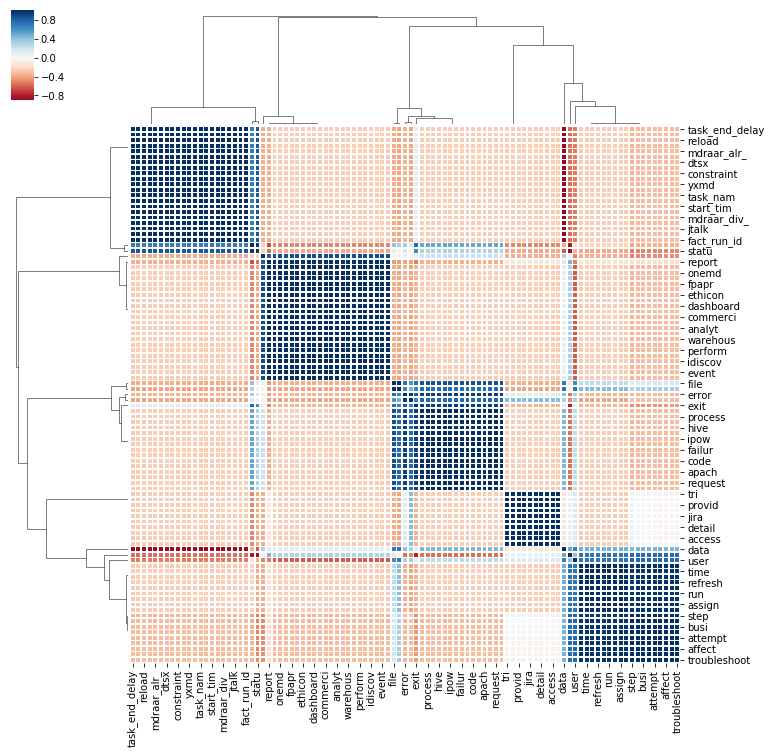

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

## Deep Learning Model Simple

In [50]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [51]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3,random_state=42)
    return X_train, X_test, y_train, y_test

In [52]:

vocab_size = len(tokenizer.word_index) + 1

In [53]:
from sklearn.externals import joblib

In [54]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Resolution Category of the ticket

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          5158912   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 7,207,043
Trainable params: 7,207,043
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 239

['model-simple_cat.pkl']

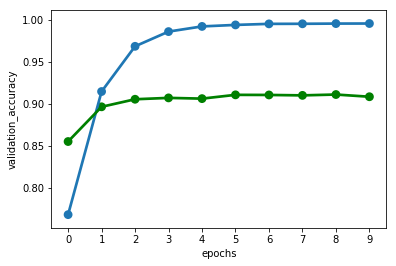

In [55]:
X_train, X_test, y_train, y_test = data_set_split(y_cat)

model_file = 'weights-simple_cat.hdf5'
model = model_training(num_class_cat, model_file)
joblib.dump(model,'model-simple_cat.pkl')

In [56]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.913960446617529

In [57]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [59]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
encoder.fit(data.Category.values)
text_labels = encoder.classes_ 


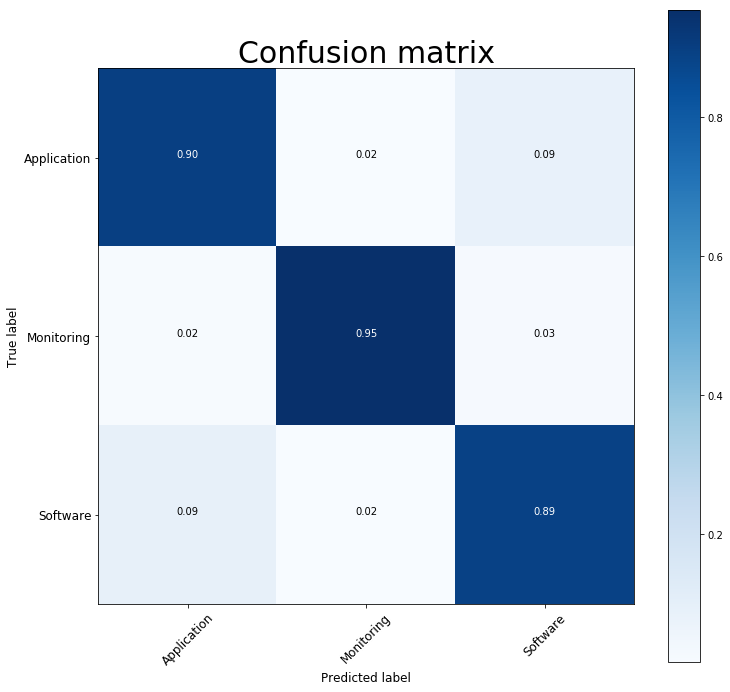

In [60]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [63]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    #LSTM(64)(embedding_layer)
    x = LSTM(100, dropout=0.5, recurrent_dropout=0.5)(embedding_layer)
    #x = Dense(32, activation='relu')(x)
    x = Dense(13, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=100, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=15, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Category using LSTM RNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 128)          5158912   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_5 (Dense)              (None, 13)                1313      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 42        
Total params: 5,251,867
Trainable params: 5,251,867
Non-trainable params: 0
_________________________________________________________________
Train on 23979 samples, validate on 7993 samples
Epoch 1/15
23979/23979 [==============================] - 124s 5ms/step - loss: 0.5

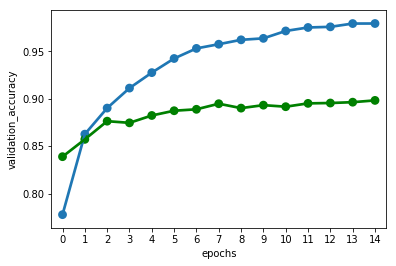

In [64]:
X_train, X_test, y_train, y_test = data_set_split(y_cat)
model_lstm = lstm_model_training(num_class_cat,"weights_cat.hdf5")
joblib.dump(model_lstm,'model_cat.pkl')
predicted = model_lstm.predict(X_test)

In [65]:
predicted = model_lstm.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.8982704517258995

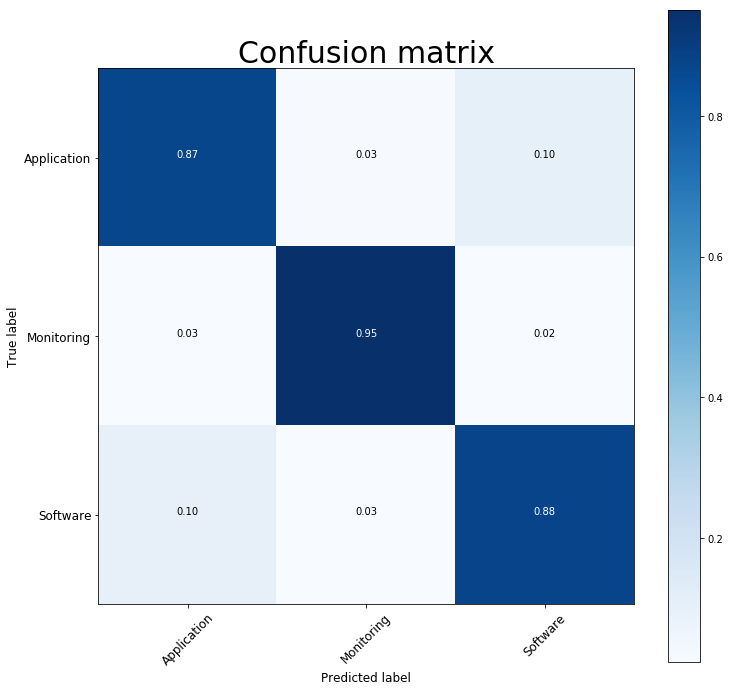

In [66]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4513
           1       0.95      0.95      0.95      4555
           2       0.88      0.88      0.88      4635

   micro avg       0.90      0.90      0.90     13703
   macro avg       0.90      0.90      0.90     13703
weighted avg       0.90      0.90      0.90     13703

